<a href="https://colab.research.google.com/github/Ragul-Kumar/Computer_Network/blob/main/Ex_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.3559 - loss: 0.7357 - val_accuracy: 0.4286 - val_loss: 0.6933
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3956 - loss: 0.6872 - val_accuracy: 0.5397 - val_loss: 0.6743
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5450 - loss: 0.6666 - val_accuracy: 0.7302 - val_loss: 0.6576
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7298 - loss: 0.6511 - val_accuracy: 0.7937 - val_loss: 0.6384
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7748 - loss: 0.6287 - val_accuracy: 0.7937 - val_loss: 0.6191
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7947 - loss: 0.6238 - val_accuracy: 0.8095 - val_loss: 0.6021
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8058 - loss: 0.5956 - val_accuracy: 0.8254 - val_loss: 0.5895
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8073 - loss: 0.5951 - val_accuracy: 0.8254 - val_loss

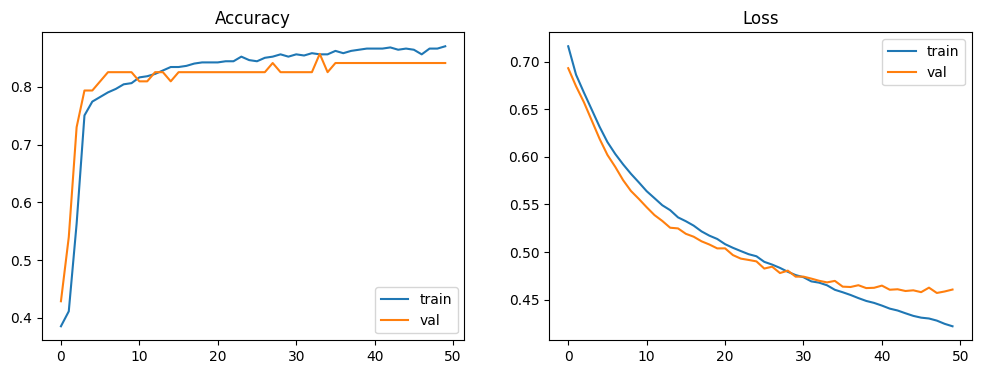

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6949 - loss: 0.6343
Test Loss: 0.6435, Test Accuracy: 0.7143


In [5]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Load dataset
url = "https://storage.googleapis.com/tf-datasets/titanic/train.csv"
df = pd.read_csv(tf.keras.utils.get_file("train.csv", url))
df.rename(columns={"survived": "target"}, inplace=True)

# 2. Split data
np.random.seed(5)
train, val, test = np.split(df.sample(frac=1), [int(0.8 * len(df)), int(0.9 * len(df))])

# 3. Convert to tf.data.Dataset
def to_dataset(df, batch_size=32):
    labels = df.pop("target")
    ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
    return ds.shuffle(len(df)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

train_ds = to_dataset(train)
val_ds = to_dataset(val)
test_ds = to_dataset(test)

# 4. Feature preprocessing layers
def norm_layer(name):
    norm = tf.keras.layers.Normalization()
    # Extract the column and reshape to (batch, 1)
    feature_ds = train_ds.map(lambda x, y: tf.expand_dims(x[name], -1))
    norm.adapt(feature_ds)
    return norm

def cat_encode_layer(name, dtype='string'):
    if dtype == 'string':
        lookup = tf.keras.layers.StringLookup(output_mode='int')
    else:
        lookup = tf.keras.layers.IntegerLookup(output_mode='int')
    feature_ds = train_ds.map(lambda x, y: tf.expand_dims(x[name], -1))
    lookup.adapt(feature_ds)

    encoder = tf.keras.layers.CategoryEncoding(
        num_tokens=lookup.vocabulary_size(),
        output_mode='one_hot'
    )
    return lambda feat: encoder(lookup(feat))

# 5. Define features
numerical = ["age", "fare"]
numerical_cats = ["n_siblings_spouses", "parch"]
categorical = ["sex", "class", "deck", "embark_town", "alone"]

inputs, encoded = [], []

for col in numerical:
    inp = tf.keras.Input(shape=(1,), name=col)
    inputs.append(inp)
    encoded.append(norm_layer(col)(inp))

for col in numerical_cats:
    inp = tf.keras.Input(shape=(1,), name=col, dtype='int64')
    inputs.append(inp)
    encoded.append(cat_encode_layer(col, dtype='int64')(inp))

for col in categorical:
    inp = tf.keras.Input(shape=(1,), name=col, dtype='string')
    inputs.append(inp)
    encoded.append(cat_encode_layer(col, dtype='string')(inp))

# 6. Build model
x = tf.keras.layers.concatenate(encoded)
for units in [32, 8, 4, 2]:
    x = tf.keras.layers.Dense(units, activation='relu')(x)
output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(inputs, output)

# 7. Compile and train
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(train_ds, validation_data=val_ds, epochs=50)

# 8. Plot training curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title("Loss")
plt.legend()
plt.show()

# 9. Evaluate and predict
loss, acc = model.evaluate(test_ds)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {acc:.4f}")

# 10. Predict on sample
sample=df.head().drop("target", axis=1)
sample_input = {
    col: np.array(sample[col]).reshape(-1, 1)
    for col in numerical + numerical_cats + categorical
}
# 10. Predict on sample
sample=df.head().drop("target", axis=1)
sample_input = {}
for col in numerical:
    sample_input[col] = np.array(sample[col]).reshape(-1, 1).astype('float32') # Ensure numerical features are float32
for col in numerical_cats:
    sample_input[col] = np.array(sample[col]).reshape(-1, 1).astype('int64') # Ensure numerical_cats features are int64
for col in categorical:
    sample_input[col] = np.array(sample[col]).reshape(-1, 1) # Keep categorical features as they are for cat_encode_layer to process


